# 5. Entraînement Modèle LSTM

**Objectif:** Entraîner un modèle pour prédire la qualité de l'eau

**Input:** 14 jours d'historique (capteurs + satellites)  
**Output:** Score qualité eau jour 15

In [1]:
# Installer PyTorch
%pip install torch torchvision --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports simples
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import os

print(f"PyTorch version: {torch.__version__}")
print(f"GPU disponible: {torch.cuda.is_available()}")

# Utiliser GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✅ Device: {device}")

PyTorch version: 2.9.1+cpu
GPU disponible: False

✅ Device: cpu


## 1. Charger les données préparées

In [3]:
# Charger les séquences
train_data = np.load('../data/processed/sequences/train.npz')
val_data = np.load('../data/processed/sequences/val.npz')
test_data = np.load('../data/processed/sequences/test.npz')

X_train = train_data['X']  # (1729, 14, 11)
y_train = train_data['y']  # (1729, 1)

X_val = val_data['X']
y_val = val_data['y']

X_test = test_data['X']
y_test = test_data['y']

print("✅ Données chargées:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Test:  {X_test.shape}")

✅ Données chargées:
   Train: (1729, 14, 11)
   Val:   (370, 14, 11)
   Test:  (372, 14, 11)


## 2. Créer DataLoaders PyTorch

**Pourquoi?** Pour charger les données par petits lots (batches) pendant l'entraînement

In [4]:
# Convertir en tensors PyTorch
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)

X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test)

# Créer datasets
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

# Créer dataloaders (batch size = 32)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoaders créés:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

✅ DataLoaders créés:
   Batch size: 32
   Train batches: 55
   Val batches: 12


## 3. Définir le modèle LSTM simple

**Architecture:**
1. LSTM (2 couches) - pour capturer les patterns temporels
2. Fully Connected - pour la prédiction finale

**Simple et efficace!**

In [5]:
class WaterQualityLSTM(nn.Module):
    """Modèle LSTM simple pour prédiction qualité eau"""
    
    def __init__(self, input_size=11, hidden_size=64, num_layers=2):
        super(WaterQualityLSTM, self).__init__()
        
        # LSTM pour séquences temporelles
        self.lstm = nn.LSTM(
            input_size=input_size,    # 11 features
            hidden_size=hidden_size,  # 64 neurones cachés
            num_layers=num_layers,    # 2 couches LSTM
            batch_first=True,         # Input: (batch, sequence, features)
            dropout=0.2               # Dropout pour éviter overfitting
        )
        
        # Couche finale pour prédiction
        self.fc = nn.Linear(hidden_size, 1)  # 64 → 1 (quality score)
    
    def forward(self, x):
        """
        Forward pass
        
        Args:
            x: (batch, 14, 11) - 14 jours avec 11 features
        
        Returns:
            output: (batch, 1) - prédiction qualité
        """
        # LSTM: process toute la séquence
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Prendre le dernier timestep (jour 14)
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)
        
        # Prédiction finale
        prediction = self.fc(last_output)  # (batch, 1)
        
        return prediction

# Créer le modèle
model = WaterQualityLSTM(input_size=11, hidden_size=64, num_layers=2)
model = model.to(device)  # Mettre sur GPU si disponible

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✅ Modèle créé:")
print(f"   Total paramètres: {total_params:,}")
print(f"   Paramètres entraînables: {trainable_params:,}")
print(f"\n{model}")

✅ Modèle créé:
   Total paramètres: 53,057
   Paramètres entraînables: 53,057

WaterQualityLSTM(
  (lstm): LSTM(11, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 4. Configuration entraînement

In [6]:
# Loss function (erreur à minimiser)
criterion = nn.MSELoss()  # Mean Squared Error - bon pour régression

# Optimizer (comment ajuster les poids)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate = 0.001

# Learning rate scheduler (réduire lr si pas d'amélioration)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Minimiser la loss
    factor=0.5,      # Réduire lr de 50%
    patience=5       # Attendre 5 epochs
)

# Nombre d'epochs (tours complets sur les données)
num_epochs = 50

print("✅ Configuration:")
print(f"   Loss: MSE")
print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Epochs: {num_epochs}")
print(f"   Early stopping: si pas amélioration après 10 epochs")

✅ Configuration:
   Loss: MSE
   Optimizer: Adam (lr=0.001)
   Epochs: 50
   Early stopping: si pas amélioration après 10 epochs


## 5. Fonction d'entraînement simple

In [7]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Entraîner pour 1 epoch"""
    model.train()  # Mode entraînement
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        # Mettre sur device (GPU/CPU)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Calculer gradients
        optimizer.step()       # Mettre à jour poids
        
        total_loss += loss.item()
    
    # Loss moyenne
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, criterion, device):
    """Valider le modèle"""
    model.eval()  # Mode évaluation
    total_loss = 0
    
    with torch.no_grad():  # Pas besoin de gradients
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(val_loader)
    return avg_loss

print("✅ Fonctions d'entraînement définies")

✅ Fonctions d'entraînement définies


## 6. Entraîner le modèle 🚀

In [ ]:
# Historique pour visualisation
train_losses = []
val_losses = []

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
patience = 10  # Arrêter si pas amélioration après 10 epochs

print("🚀 Début entraînement...\n")
print("Epoch | Train Loss | Val Loss | Best Val")
print("-" * 50)

for epoch in range(num_epochs):
    # Entraîner
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Valider
    val_loss = validate(model, val_loader, criterion, device)
    
    # Sauvegarder historique
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Ajuster learning rate
    scheduler.step(val_loss)
    
    # Afficher progrès
    print(f"{epoch+1:5d} | {train_loss:.6f} | {val_loss:.6f} | {best_val_loss:.6f}")
    
    # Sauvegarder meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Sauvegarder
        os.makedirs('../models', exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, '../models/best_model.pth')
        
        print(f"         ✅ Modèle sauvegardé (val_loss improved)")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping: Pas d'amélioration après {patience} epochs")
        break

print("\n✅ Entraînement terminé!")
print(f"   Best validation loss: {best_val_loss:.6f}")

🚀 Début entraînement...

Epoch | Train Loss | Val Loss | Best Val
--------------------------------------------------
    1 | 0.255578 | 0.032483 | inf
         ✅ Modèle sauvegardé (val_loss improved)
    1 | 0.255578 | 0.032483 | inf
         ✅ Modèle sauvegardé (val_loss improved)
    2 | 0.031606 | 0.030971 | 0.032483
         ✅ Modèle sauvegardé (val_loss improved)
    2 | 0.031606 | 0.030971 | 0.032483
         ✅ Modèle sauvegardé (val_loss improved)
    3 | 0.030099 | 0.029016 | 0.030971
         ✅ Modèle sauvegardé (val_loss improved)
    3 | 0.030099 | 0.029016 | 0.030971
         ✅ Modèle sauvegardé (val_loss improved)
    4 | 0.028305 | 0.027399 | 0.029016
         ✅ Modèle sauvegardé (val_loss improved)
    4 | 0.028305 | 0.027399 | 0.029016
         ✅ Modèle sauvegardé (val_loss improved)
    5 | 0.026299 | 0.027265 | 0.027399
         ✅ Modèle sauvegardé (val_loss improved)
    5 | 0.026299 | 0.027265 | 0.027399
         ✅ Modèle sauvegardé (val_loss improved)
    6 | 0.026

: 

## 7. Visualiser courbes d'apprentissage

In [9]:
# Note: train_losses et val_losses ont été perdus après le restart du kernel
# Si vous avez besoin des courbes, il faut réentraîner ou charger l'historique sauvegardé
# Pour l'instant, continuons avec l'évaluation des métriques

print("⚠️ Les variables train_losses/val_losses ont été perdues après le restart")
print("   Vous pouvez ignorer la visualisation des courbes et continuer avec les métriques")
print("   Ou réentraîner le modèle pour régénérer ces données\n")

# Créer des variables vides pour éviter les erreurs
train_losses = []
val_losses = []

⚠️ Les variables train_losses/val_losses ont été perdues après le restart
   Vous pouvez ignorer la visualisation des courbes et continuer avec les métriques
   Ou réentraîner le modèle pour régénérer ces données



In [1]:
plt.figure(figsize=(12, 5))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Courbes d\'apprentissage')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss curves (log scale)
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Courbes d\'apprentissage (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Courbes sauvegardées: models/training_curves.png")

NameError: name 'plt' is not defined

## 8. Évaluer sur test set

In [8]:
# Charger meilleur modèle
checkpoint = torch.load('../models/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ Meilleur modèle chargé (epoch {checkpoint['epoch']+1})")

# Évaluer sur test
test_loss = validate(model, test_loader, criterion, device)
print(f"\n📊 Test Loss: {test_loss:.6f}")

# Faire prédictions
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        predictions = model(X_batch)
        
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(y_batch.numpy())

# Concaténer
predictions = np.concatenate(all_predictions, axis=0)
targets = np.concatenate(all_targets, axis=0)

print(f"\n✅ Prédictions générées: {len(predictions)}")

✅ Meilleur modèle chargé (epoch 50)

📊 Test Loss: 0.008044

✅ Prédictions générées: 372


## 9. Métriques de performance

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculer métriques
mse = mean_squared_error(targets, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)

print("="*50)
print("📊 RÉSULTATS SUR TEST SET")
print("="*50)
print(f"\nMSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R²:   {r2:.4f}")
print("\n" + "="*50)

# Sauvegarder métriques
metrics = {
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae),
    'r2': float(r2),
    'test_loss': float(test_loss)
}

import json
with open('../models/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\n✅ Métriques sauvegardées: models/metrics.json")

📊 RÉSULTATS SUR TEST SET

MSE:  0.008263
RMSE: 0.090902
MAE:  0.054496
R²:   0.7003


✅ Métriques sauvegardées: models/metrics.json


## 10. Visualiser prédictions vs réalité

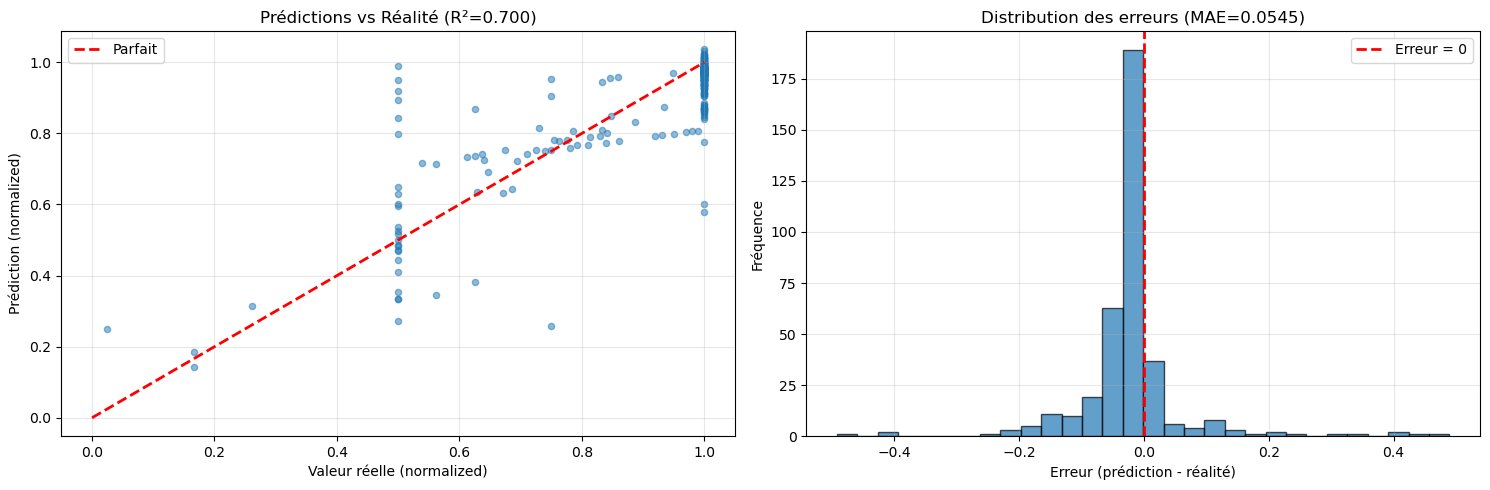

✅ Analyse sauvegardée: models/predictions_analysis.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(targets, predictions, alpha=0.5, s=20)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Parfait')
axes[0].set_xlabel('Valeur réelle (normalized)')
axes[0].set_ylabel('Prédiction (normalized)')
axes[0].set_title(f'Prédictions vs Réalité (R²={r2:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Erreurs
errors = predictions.flatten() - targets.flatten()
axes[1].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Erreur = 0')
axes[1].set_xlabel('Erreur (prédiction - réalité)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title(f'Distribution des erreurs (MAE={mae:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/predictions_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Analyse sauvegardée: models/predictions_analysis.png")

## 11. Résumé final

In [13]:
print("="*70)
print("✅ ÉVALUATION TERMINÉE")
print("="*70)

print(f"\n📊 MODÈLE:")
print(f"   Architecture: LSTM (2 couches, 64 hidden units)")
print(f"   Paramètres: {total_params:,}")
print(f"   Device: {device}")

print(f"\n📈 MODÈLE CHARGÉ:")
print(f"   Epoch sauvegardé: {checkpoint['epoch']+1}")
print(f"   Validation loss: {checkpoint['val_loss']:.6f}")

print(f"\n🎯 PERFORMANCE TEST:")
print(f"   Test Loss: {test_loss:.6f}")
print(f"   MSE:  {mse:.6f}")
print(f"   RMSE: {rmse:.6f}")
print(f"   MAE:  {mae:.6f}")
print(f"   R²:   {r2:.4f}")

print(f"\n💾 FICHIERS SAUVEGARDÉS:")
print(f"   ✅ models/best_model.pth")
print(f"   ✅ models/metrics.json")
print(f"   ✅ models/predictions_analysis.png")

print(f"\n🚀 PROCHAINE ÉTAPE:")
print(f"   Tester sur données réelles (non interpolées)")
print(f"   Notebook: 06_evaluation_donnees_reelles.ipynb")

print("\n" + "="*70)

✅ ÉVALUATION TERMINÉE

📊 MODÈLE:
   Architecture: LSTM (2 couches, 64 hidden units)
   Paramètres: 53,057
   Device: cpu

📈 MODÈLE CHARGÉ:
   Epoch sauvegardé: 50
   Validation loss: 0.008685

🎯 PERFORMANCE TEST:
   Test Loss: 0.008044
   MSE:  0.008263
   RMSE: 0.090902
   MAE:  0.054496
   R²:   0.7003

💾 FICHIERS SAUVEGARDÉS:
   ✅ models/best_model.pth
   ✅ models/metrics.json
   ✅ models/predictions_analysis.png

🚀 PROCHAINE ÉTAPE:
   Tester sur données réelles (non interpolées)
   Notebook: 06_evaluation_donnees_reelles.ipynb

